# Proof of Concept for Downloading YouTube videos from AudioSet

First, we'll start by showing that our video-download, audio-download, and data viz function(s) are working properly by testing them on a YouTube video copied/pasted directly here.
If those all work, we'll try to replicate that success with a URL assembled from the AudioSet CSVs.

In [58]:
import pafy
import sox
import librosa
import matplotlib
import skimage
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

Alex introduced us to a motivational video during w241's harder problem sets. We'll start with that.

In [21]:
url = 'https://www.youtube.com/watch?v=ZXsQAXx_ao0'
shia = pafy.new(url)
shia.title

'Shia LaBeouf "Just Do It" Motivational Speech (Original Video by LaBeouf, Rönkkö & Turner)'

There are a whole bundle of attributes we can extract from this if we so choose. Rather than belabor that, let's just see what is most important to us: the videostream and the audiostream.

In [26]:
print("Video:")
for s in shia.streams:
    print(f'\t{s}')
print("Audio:")
for a in shia.audiostreams:
    print(f'\t{a}')

Video:
	normal:mp4@640x360
	normal:mp4@1280x720
Audio:
	audio:webm@50k
	audio:webm@70k
	audio:m4a@128k
	audio:webm@160k


We can let Pafy decide which of those is the highest quality, and let it go get that for us. But first, we need a place to put it.

In [ ]:
!mkdir /home/projects/data/poc

In [70]:
shia_video = shia.getbest().download(filepath='/home/projects/data/poc/shia_video.mp4')

  4,248,745.0 Bytes [100.00%] received. Rate: [8659 KB/s].  ETA: [0 secs]    


This will be useful in a second, where we go ahead and prove that we can extract the audio from the video using `ffmpeg`. But for the moment, we can also just extract the audiostream directly.

In [64]:
shia_audio = shia.getbestaudio().download(filepath='/home/projects/data/poc/shia_audio.mp3')

  1,002,502.0 Bytes [100.00%] received. Rate: [2926 KB/s].  ETA: [0 secs]    


Since we were able to download the audio directly, let's have `librosa` give us a look at what we've got on the audio front. If we're able to recover something similar from our audio-extraction-from-mp4 process, we'll have more confidence it worked.

/home/tslade/miniconda3/envs/tslade/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


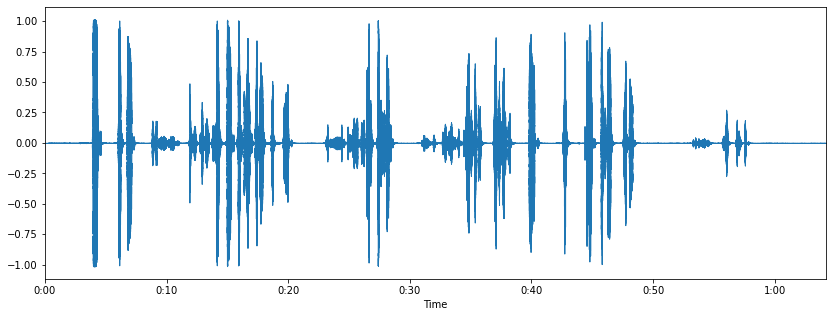

In [77]:
audio_wav, sr = librosa.load('/home/projects/data/poc/shia_audio.mp3')
plt.figure(figsize=(14, 5))
native_audio_graph = librosa.display.waveplot(audio_wav, sr=sr)

In [71]:
! ffmpeg -i /home/projects/data/poc/shia_video.mp4 /home/projects/data/poc/shia_audio_extracted.mp3

ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/tslade/miniconda3/envs/tslade --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/pr

/home/tslade/miniconda3/envs/tslade/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


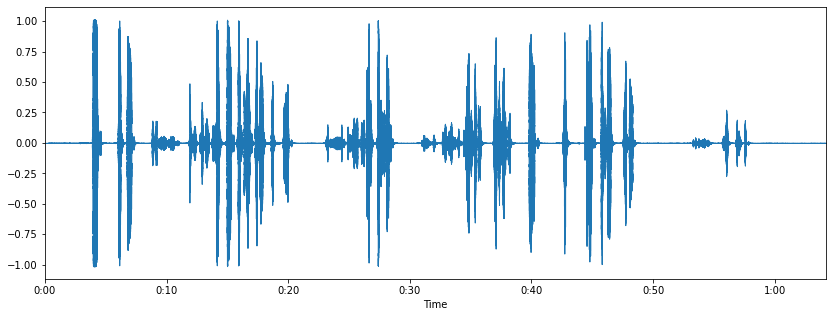

In [74]:
video_wav, vsr = librosa.load('/home/projects/data/poc/shia_audio.mp3')
plt.figure(figsize=(14, 5))
extracted_audio_graph = librosa.display.waveplot(video_wav, sr=vsr)

That's looking pretty good! Let's stack them up and see...

In [82]:
# plt.subplot(2, 1, 1)
# native_audio_graph
# plt.subplot(2, 1, 2)
# extracted_audio_graph
# plt.show()

**NB: Turns out it's not as simple as storing an object and showing it later. We'll come back to this, and just show it the old-skool way**

In [63]:
# !rm -rf tslade-projects/data/poc
!ls -lah tslade-projects/data/poc

total 5.1M
drwxrwxr-x 2 tslade tslade 4.0K Jun  2 00:20 .
drwxrwxr-x 4 tslade tslade 4.0K Jun  2 00:20 ..
-rw-rw-r-- 1 tslade tslade 980K Dec  6  2017 shia_audio
-rw-rw-r-- 1 tslade tslade 4.1M Dec  6  2017 shia_video


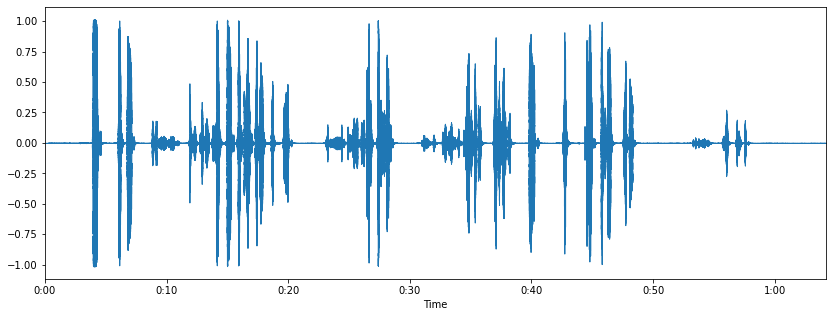

In [86]:
plt.figure(figsize=(14, 5))
native_audio_graph = librosa.display.waveplot(audio_wav, sr=sr)

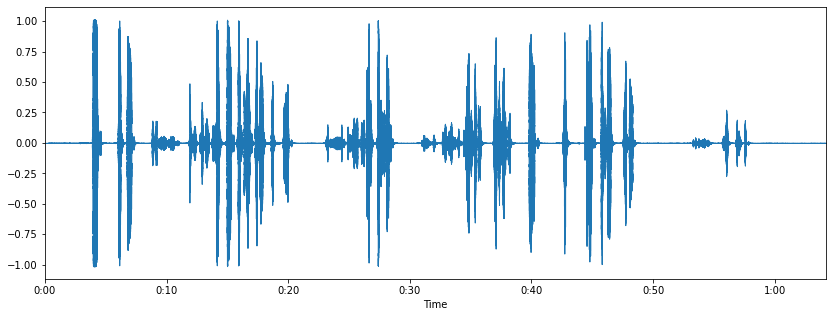

In [87]:
plt.figure(figsize=(14, 5))
extracted_audio_graph = librosa.display.waveplot(video_wav, sr=vsr)

I think we've got it!

## Downloading from a cobbled-together AudioSet CSV line

In [88]:
!head -5 /home/projects/data/audioset/balanced_train_segments.csv

# Segments csv created Sun Mar  5 10:54:31 2017
# num_ytids=22160, num_segs=22160, num_unique_labels=527, num_positive_labels=52882
# YTID, start_seconds, end_seconds, positive_labels
--PJHxphWEs, 30.000, 40.000, "/m/09x0r,/t/dd00088"
--ZhevVpy1s, 50.000, 60.000, "/m/012xff"


Let's see if we can pull down both of those YouTube video segments. We'll do it using the native-audio method.

In [ ]:
def grab_audioset_clip(ytid, stime, etime, outfile):
    """ Download a segment from a YouTube video
        based on its YouTube ID and timestamps marking the
        beginning and end
        
        ytid [str]    = 9-char. case-sensitive string
        stime [num]   = timestamp (seconds) for the segment's start
        etime [num]   = timestamp (seconds) for the segment's end
        outfile [str] = path (relative to cwd) inclusive of filename
                        and extension
    """
    url = f'https://www.youtube.com/watch?v={}?start={stime}&end={etime}'
    target = pafy.new(url)
    
    
    
    

In [18]:
!ls -lah tslade-projects/

total 16K
drwxrwxr-x 4 tslade tslade 4.0K May 31 15:36 .
drwxr-xr-x 9 root   root   4.0K Jun  1 22:10 ..
drwxrwxr-x 3 tslade tslade 4.0K Jun  1 23:54 data
drwxrwxr-x 6 tslade tslade 4.0K Jun  1 04:16 teacherprints


In [91]:
test = pafy.new('https://www.youtube.com/watch?v=6sylWCdiuTA?start=20&end=25')
test.title

ValueError: Need 11 character video id or the URL of the video. Got https://www.youtube.com/watch?v=6sylWCdiuTA?start=20&end=25

In [104]:
!ffmpeg $(youtube-dl -g 'https://www.youtube.com/watch?v=NnW5EjwtE2U' -f bestaudio | sed "s/.*/-ss 10 -i &/") -t 60 -c copy /home/projects/data/poc/test32.mp3

ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/tslade/miniconda3/envs/tslade --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, matroska,webm, from 'https://r4---sn-vg

In [95]:
import IPython.display as ipd
# ipd.Audio('test3.mkv')
ipd.Audio('/home/projects/data/poc/shia_audio.mp3')

In [124]:
ipd.Audio('/home/projects/data/poc/testing35.mp3')

In [125]:
import youtube_dl
# ydl_opts = {
#     'format': 'bestaudio/best',
#     'postprocessors': [{
#         'key': 'FFmpegExtractAudio',
#         'preferredcodec': 'mp3',
#         'preferredquality': '192',
#     }],
# #     'prefer_ffmpeg': True,
#     'keepvideo': False,
#     'outtmpl': '/home/projects/data/poc/testing33',
# }
ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
        'preferredquality': '192',
    }],
    'outtmpl': '/home/projects/data/poc/testing38.mp3',
}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/embed/6sylWCdiuTA?start=20&end=25'])

[youtube] 6sylWCdiuTA: Downloading webpage
[youtube] 6sylWCdiuTA: Downloading MPD manifest
[dashsegments] Total fragments: 20
[download] Destination: /home/projects/data/poc/testing38.mp3
[download] 100% of 2.33MiB in 00:02.17MiB/s ETA 00:00002
[ffmpeg] Post-process file /home/projects/data/poc/testing38.mp3 exists, skipping


In [126]:
ipd.Audio('/home/projects/data/poc/testing38.mp3')